In [1]:
import pandas as pd

In [18]:
s1 = "HD"
s2 = "CVS"

In [19]:
import quandl
import datetime

quandl.ApiConfig.api_key =  "NVrKn2Y8HrPv4KzRQPXN"

start =  datetime.datetime(2015,4,1)
end =  datetime.datetime(2018,4,1)

stock1 = quandl.get("WIKI/" + s1, start_date = start, end_date = end)
#type(stock1)
stock1.to_csv('price_{}.csv'.format(s1))

stock2 = quandl.get("WIKI/" + s2, start_date = start, end_date = end)
#type(stock2)
stock2.to_csv('price_{}.csv'.format(s2))

In [11]:
# Assuming you have two DataFrames named 'gold' and 'silver'
# Select only the necessary columns and rename them
stock1_cleaned = stock1[['USD (PM)']].rename(columns={'USD (PM)': s1})
stock2_cleaned = stock2[['USD']].rename(columns={'USD': s2})

In [20]:
# Assuming you have two DataFrames named 'gold' and 'silver'
# Select only the necessary columns and rename them
stock1_cleaned = stock1[['Close']].rename(columns={'Close': s1})
stock2_cleaned = stock2[['Close']].rename(columns={'Close': s2})

In [21]:
# Assuming you have two DataFrames named 'gold' and 'silver'
# Combine them into one DataFrame
combined_df = pd.concat([stock1_cleaned, stock2_cleaned], axis=1)

# Optionally, you can rename the columns to differentiate between gold and silver
combined_df.columns = [s1, s2]


combined_df.to_csv('Combined_{}_{}.csv'.format(s1, s2))

# Display the combined DataFrame
print(combined_df.head())

                HD     CVS
Date                      
2015-04-01  113.13  102.26
2015-04-02  114.54  102.71
2015-04-06  114.95  103.43
2015-04-07  114.30  103.13
2015-04-08  115.59  102.93


In [22]:
stocks_df = 'Combined_{}_{}.csv'.format(s1, s2)

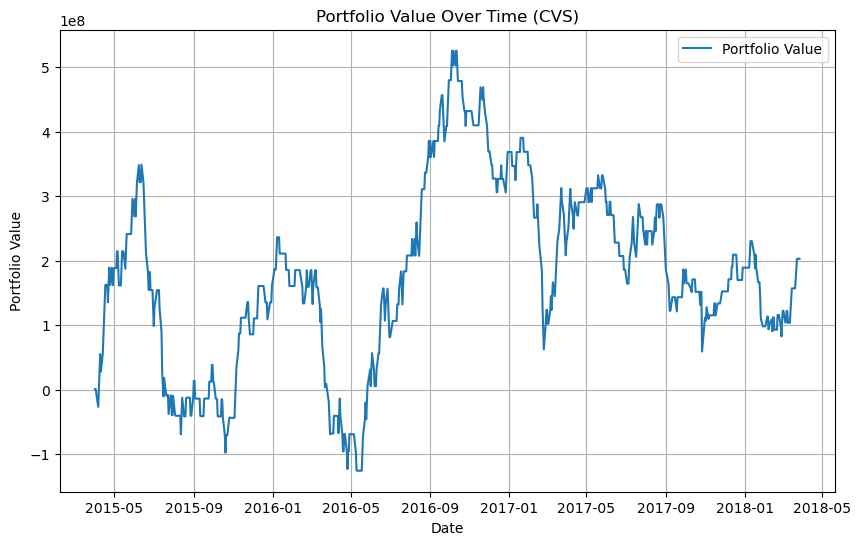

Sharpe Ratio: 0.34730383347263616


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the historical data
data = pd.read_csv(stocks_df, index_col='Date', parse_dates=True)

# Calculate daily returns
data['s1_return'] = data[s1].pct_change()
data['s2_return'] = data[s2].pct_change()

# Calculate rolling volatility for Gold and Silver
rolling_window = 2
data['Rolling_Volatility_stock1'] = data['s1_return'].rolling(window=rolling_window).std() * np.sqrt(252)
data['Rolling_Volatility_stock2'] = data['s2_return'].rolling(window=rolling_window).std() * np.sqrt(252)

# Calculate average and standard deviation of rolling volatility for Gold
average_rolling_volatility_s1 = data['Rolling_Volatility_stock1'].mean()

# Define thresholds for trade activation for Silver based on Gold volatility
volatility_threshold_upper = average_rolling_volatility_s1
volatility_threshold_lower = average_rolling_volatility_s1

# Initialize variables
initial_portfolio_value = 1_000_000
current_portfolio_value = initial_portfolio_value
open_positions = []  # List to track open positions
portfolio_values = [current_portfolio_value] * len(data)  # Start with the initial portfolio value for each date

# Stop loss and take profit thresholds (as a percentage)
stop_loss_threshold = 0.02  # 2%
take_profit_threshold = 0.05  # 3%

# Simulate the backtest
for index, row in enumerate(data.itertuples()):
    # Check if any open position can be closed due to stop loss or take profit
    for pos in open_positions:
        pnl = (row[2] - pos['price']) * pos['position']
        if pnl <= -current_portfolio_value * stop_loss_threshold or pnl >= current_portfolio_value * take_profit_threshold:
            current_portfolio_value += pnl
            open_positions.remove(pos)
    
    # Buy or sell Silver based on adjusted conditions and Gold volatility
    if row.s2_return > 0:
        if row.Rolling_Volatility_stock2 > volatility_threshold_upper and row.Rolling_Volatility_stock1 < 0:
            # Sell Silver if return is positive and Gold volatility is negative
            stock2_to_sell = 265000
            current_portfolio_value += stock2_to_sell * row[2]
            open_positions.append({'position': -stock2_to_sell, 'price': row[2]})
        elif row.Rolling_Volatility_stock2 < volatility_threshold_lower and row.Rolling_Volatility_stock1 > 0:
            # Buy Silver if return is positive and Gold volatility is positive
            stock2_to_buy = 265000
            current_portfolio_value -= stock2_to_buy * row[2]
            open_positions.append({'position': stock2_to_buy, 'price': row[2]})
    else:
        if row.Rolling_Volatility_stock2 > volatility_threshold_upper and row.Rolling_Volatility_stock1 < 0:
            # Buy Silver if return is negative and Gold volatility is negative
            stock2_to_buy = 265000
            current_portfolio_value -= stock2_to_buy * row[2]
            open_positions.append({'position': stock2_to_buy, 'price': row[2]})
        elif row.Rolling_Volatility_stock2 < volatility_threshold_lower and row.Rolling_Volatility_stock1 > 0:
            # Sell Silver if return is negative and Gold volatility is positive
            stock2_to_sell = 265000
            current_portfolio_value += stock2_to_sell * row[2]
            open_positions.append({'position': -stock2_to_sell, 'price': row[2]})
    
    # Update portfolio value at each time period
    portfolio_values[index] = current_portfolio_value

# Plot the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(data.index, portfolio_values, label='Portfolio Value')
plt.title('Portfolio Value Over Time ({})'.format(s2))
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Sharpe Ratio
portfolio_returns = pd.Series(portfolio_values).pct_change()
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio)
